In [1]:
%matplotlib widget

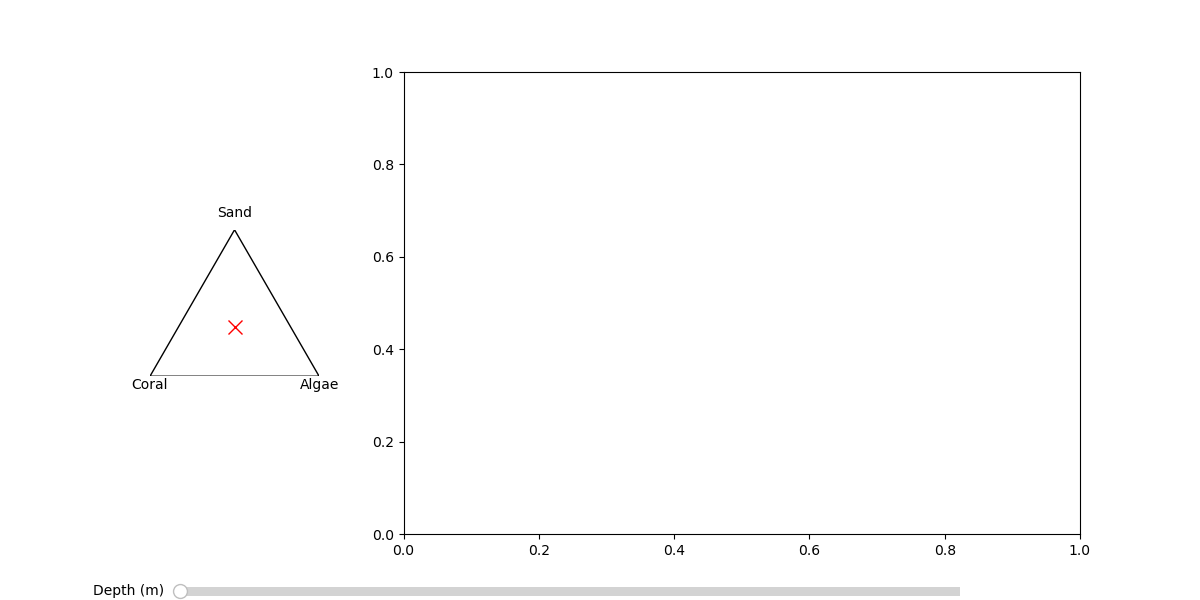

In [2]:
import numpy as np

# general
import numpy as np

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.widgets import Slider
from matplotlib.path import Path as pPath

# custom
from reflectance import file_ops

# Load fractional spectra
frac_spectra = np.load(file_ops.TMP_DIR_FP / "fractional_spectra.npy")
wvs = np.load(file_ops.TMP_DIR_FP / "wavelengths.npy")
fracs = np.load(file_ops.TMP_DIR_FP / "fracs.npy")

# Define the vertices of the triangle (100% coral, algae, sand)
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

MAX_DEPTH = 10  # maximum depth in meters   # TODO: make this less hard-coded
# Define the colours for the three components (vertices)
COLOURS = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])


def get_proportions(point: tuple[float, float], triangle: tuple[tuple[float, float]]):
    """Calculate barycentric coordinates (https://mathworld.wolfram.com/BarycentricCoordinates.html)
    of a point within a triangle."""

    def area(p1: tuple[float, float], p2: tuple[float, float], p3: tuple[float, float]):
        """Calculate area of triangle given 3 points."""
        return 0.5 * abs(
            p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1])
        )

    total_area = area(*triangle)
    coral_prop = area(point, triangle[1], triangle[2]) / total_area
    algae_prop = area(point, triangle[2], triangle[0]) / total_area
    sand_prop = area(point, triangle[0], triangle[1]) / total_area

    return coral_prop, algae_prop, sand_prop


def closest_point_in_triangle(
    point: tuple[float, float], triangle: tuple[tuple[float, float]]
):
    """In the event that the point is outside the triangle, find the closest point on the triangle."""
    path = pPath(triangle)
    if path.contains_point(point):
        return point
    else:
        # Project point onto the nearest edge of the triangle
        min_distance = float("inf")
        closest_point = None  # store closest point
        for i in range(3):  # iterate over triangle edges
            v0, v1 = triangle[i], triangle[(i + 1) % 3]  # get vertices
            projection = np.dot(point - v0, v1 - v0) / np.linalg.norm(v1 - v0) ** 2
            projection = np.clip(projection, 0, 1)
            proj_point = v0 + projection * (v1 - v0)
            distance_to_proj = np.linalg.norm(point - proj_point)
            # check that this is the closest point to any of the sides yet
            if distance_to_proj < min_distance:
                min_distance = distance_to_proj
                closest_point = proj_point
        return closest_point


def update_spectrum(val):
    """Update spectrum plot based on slider value."""
    depth = slider_depth.val
    depths = np.linspace(0, MAX_DEPTH, frac_spectra.shape[3])
    # make sure the depth index is within bounds
    depth = np.clip(depth, 0, frac_spectra.shape[3] - 1)

    coral_prop, algae_prop, sand_prop = get_proportions([point_x, point_y], triangle)
    # find the closest spectrum for the given proportion
    coral_index = np.argmin(np.abs(fracs - coral_prop))
    algae_index = np.argmin(np.abs(fracs - algae_prop))
    sand_index = np.argmin(np.abs(fracs - sand_prop))

    nearest_spectrum = frac_spectra[coral_index, algae_index, sand_index, depth]

    # generate grid of colours within the triangle
    # spectrum_colours = generate_triangle_grid_colours(n_points=100)
    # mix the colours based on barycentric coordinates
    spectrum_colour = np.clip(
        np.dot((coral_prop, algae_prop, sand_prop), COLOURS), 0, 1
    )

    # update and format the spectrum plot
    ax_spectrum.clear()
    ax_spectrum.set_ylim(0, 0.1)
    ax_spectrum.set_xlim(wvs[0], wvs[-1])
    ax_spectrum.plot(wvs, nearest_spectrum, color=spectrum_colour)
    ax_spectrum.set_title(
        f"Nearest Spectrum: Coral {coral_prop:.2f}, Algae {algae_prop:.2f}, Sand {sand_prop:.2f}, Depth {depths[depth]:.2f}m",
        pad=10,
    )
    ax_spectrum.set_xlabel("Wavelength (nm)")
    ax_spectrum.set_ylabel("Reflectance")
    fig.canvas.draw_idle()


def on_drag(event: matplotlib.backend_bases.MouseEvent):
    """
    Handle mouse drag event to update the position of a point within a triangle and
    display the corresponding proportions of coral, algae, and sand.

    Parameters:
    event (matplotlib.backend_bases.MouseEvent): The mouse event containing information
    about the drag action, including the new coordinates of the point.

    Returns:
    None
    """
    """Handle mouse drag event."""
    global point_x, point_y  # store coordinates of point being dragged globally
    if event.inaxes == ax:  # if outside axes, do nothing
        new_point_x, new_point_y = event.xdata, event.ydata
        new_point = np.array([new_point_x, new_point_y])
        # constrain point to within triangle
        constrained_point = closest_point_in_triangle(new_point, triangle)
        point_x, point_y = constrained_point
        point.set_data([point_x], [point_y])
        coral_prop, algae_prop, sand_prop = get_proportions(
            [point_x, point_y], triangle
        )
        # proportion_text.set_text(
        #     f"Coral: {coral_prop:.2f}, Algae: {algae_prop:.2f}, Sand: {sand_prop:.2f}"
        # )
        update_spectrum(slider_depth.val)


# initialize plot
fig, (ax, ax_spectrum) = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[1, 4])
# format
ax.set_aspect("equal")
ax.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5 * np.tan(np.pi / 3))

# draw triangle
tri_patch = Polygon(triangle, closed=True, fill=None, edgecolor="black")
ax.add_patch(tri_patch)
# set initial point as centre of triangle
point_x, point_y = 0.5, np.sqrt(3) / 6
(point,) = ax.plot([point_x], [point_y], "rx", markersize=10)

# triangle proportions text
proportion_text = ax.text(0.2, -0.2, "", transform=ax.transAxes)
# label triangle vertices
ax.text(0, -0.05, "Coral", ha="center", va="center")
ax.text(1, -0.05, "Algae", ha="center", va="center")
ax.text(0.5, 0.1 + np.sqrt(3) / 2, "Sand", ha="center", va="center")

# depth slider
ax_slider_depth = plt.axes([0.15, 0, 0.65, 0.03], facecolor="lightgoldenrodyellow")
slider_depth = Slider(
    ax_slider_depth, "Depth (m)", 0, frac_spectra.shape[3] - 1, valinit=0, valstep=1
)
slider_depth.valtext.set_visible(False)

# connect mouse movement over figure to on_drag function
fig.canvas.mpl_connect("motion_notify_event", on_drag)
# connect slider movement to update_spectrum function
slider_depth.on_changed(update_spectrum)

fig.canvas.manager.set_window_title('')  # Remove window title


plt.show(block=False)